## Install Prereqs

In [1]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install tensorflow_datasets
!pip install matplotlib
!pip install pillow

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt
import os

from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

from PIL import Image

import numpy as np

dataset_path = '../Data/Dataset/SCDEncoded/'
map_path = '../Data/Dataset/BetaMap/'
models_path = '../Models/'
model_name = 'U-Net_Faces_SCD'
training_data = 'Training/'
test_data = 'Testing/'

## Configs?

In [3]:
# TCD CONFIGS
NUM_STAIRS = 2

# DATASET CONFIGS
TRAINSET_SIZE = len(os.listdir(dataset_path + training_data))
print(f"The Training Dataset contains {TRAINSET_SIZE} images.")
TESTSET_SIZE = len(os.listdir(dataset_path + test_data))
print(f"The Testing Dataset contains {TESTSET_SIZE} images.")

# DATASET PARAMETERS
SEED = 123
TRAIN_LENGTH = TRAINSET_SIZE
BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

The Training Dataset contains 919 images.
The Testing Dataset contains 230 images.


## Check GPU Running and Configs

In [4]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Helper functions

In [5]:
def parse_image(img_path: str) -> dict:
    image = tf.io.read_file(img_path)
    image = tf.image.decode_png(image, channels=3, dtype=tf.dtypes.uint8)
    
    depth_path = tf.strings.regex_replace(img_path, 'Dataset/SCDEncoded/Testing/', '')
    depth_path = tf.strings.regex_replace(depth_path, 'Dataset/SCDEncoded/Training/', '')
    depth_path = tf.strings.regex_replace(depth_path, '_SCD_Encoded', '')
    depth = tf.io.read_file(depth_path)
    depth = tf.image.decode_png(depth, channels = 1)
    
    return {'image': image, 'segmentation_mask': depth}
    
    
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

@tf.function
def load_image_train(datapoint):
    ### Don't resize, crop instead! :^) 
    input_image = tf.image.resize_with_crop_or_pad(datapoint['image'], 512, 512)
    input_mask = tf.image.resize_with_crop_or_pad(datapoint['segmentation_mask'], 512, 512)

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize_with_crop_or_pad(datapoint['image'], 512, 512)
    input_mask = tf.image.resize_with_crop_or_pad(datapoint['segmentation_mask'], 512, 512)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def add_gaussian_blur(image):
    image = tf.expand_dims(image, 0)
    image = tf.cast(image, tf.float32)
    blur = [tf.divide(tf.constant([[1, 2, 1], [2, 4, 2], [1, 2, 1]], dtype = tf.float32), 16.0)]
    blur = tf.expand_dims(blur, axis = -1)
    blur = tf.transpose(blur, [1,2,3,0])
    blurred_image = tf.nn.conv2d(image, blur, strides = (1,1), padding = 'SAME')[0]
    return blurred_image

## More helper functions for images

In [6]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'Predicted Mask', 'True Depth', 'Predicted Depth', 'Difference Image']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        # plt.axis('off')
    plt.show()
    
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, depth in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], depth[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])
        
def evaluate_predictions(dataset=None, num=1):
    if dataset:
        for image, depth, in dataset.take(num):
            pred_mask = model.predict(image)
            mask = create_mask(pred_mask)
            decoded_depth = scdDecode(image[0], mask, depth[0], verbose = True)
            
#            print(np.unique(depth[0]))
            blurred_depth = add_gaussian_blur(depth[0])
#            print(np.unique(blurred_depth))
            
#            print('Actual', 'Min Depth:', np.min(depth[0]), 'Max Depth:', np.max(depth[0]))
            print('Actual', 'Min Depth:', np.min(blurred_depth), 'Max Depth:', np.max(blurred_depth))
            print('Predicted', 'Min Depth:', np.min(decoded_depth), 'Max Depth:', np.max(decoded_depth))
                        
            display([image[0], mask, depth[0], decoded_depth, depth[0] - decoded_depth])
            
def evaluate_all_data(dataset=None, save_images=False, train=False):
      
    if dataset:
        num_images = 0
        total_sum_squared_diff = 0
        for batch in dataset:
            images = batch[0]
            depths = batch[1]
            
            for i in range(0, len(images)):
                image = images[i]
                depth = depths[i]
                depth = add_gaussian_blur(depth)
                
                if save_images:
                    if train:
                        # Save Encoded Images to Data/Dataset/Encoded_Images/Testing
                        encoded_image = tf.keras.preprocessing.image.array_to_img(image)
                        plt.imsave('../Data/Dataset/Encoded_Image/Training/' + str(num_images + i + 1) + '_SCD_Encoded_Image.png', np.uint8(encoded_image)/255.0)  
                    else: 
                        # Save Encoded Images to Data/Dataset/Encoded_Images/Testing
                        encoded_image = tf.keras.preprocessing.image.array_to_img(image)
                        plt.imsave('../Data/Dataset/Encoded_Image/Testing/' + str(num_images + i + 1) + '_SCD_Encoded_Image.png', np.uint8(encoded_image)/255.0)  
                    
                image = tf.reshape(image, [-1, 512, 512, 3]) # -1 to get None first dimensions         
                
                pred_mask = model.predict(image)
                mask = create_mask(pred_mask)
        
                decoded_depth = scdDecode(image[0], mask, depth)
                if save_images:
                    if train:
                        # Save Gamma Maps to Data/Dataset/Gamma_Map/Testing
                        gamma_map = tf.keras.preprocessing.image.array_to_img(mask)
                        plt.imsave('../Data/Dataset/Gamma_Map/Training/' + str(num_images + i + 1) + '_SCD_Gamma_Map.png', gamma_map)
                        # Save Predicted Z to Data/Dataset/Predicted_Depth/Testing
                        decoded_depth_image = tf.keras.preprocessing.image.array_to_img(decoded_depth)
                        decoded_depth_image.save('../Data/Dataset/Predicted_Depth_Grayscale/Training/' + str(num_images + i + 1) + '_SCD_Predicted_Depth.png')
                        plt.imsave('../Data/Dataset/Predicted_Depth/Training/' + str(num_images + i + 1) + '_SCD_Predicted_Depth.png', decoded_depth_image)
                        # Save Original Z to Data/Dataset/Original_Depth/Testing
                        original_depth_image = tf.keras.preprocessing.image.array_to_img(depth)
                        original_depth_image.save('../Data/Dataset/Original_Depth_Grayscale/Training/' + str(num_images + i + 1) + '_SCD_Original_Depth.png')
                        plt.imsave('../Data/Dataset/Original_Depth/Training/' + str(num_images + i + 1) + '_SCD_Original_Depth.png', original_depth_image)
                    else:
                        # Save Gamma Maps to Data/Dataset/Gamma_Map/Testing
                        gamma_map = tf.keras.preprocessing.image.array_to_img(mask)
                        plt.imsave('../Data/Dataset/Gamma_Map/Testing/' + str(num_images + i + 1) + '_SCD_Gamma_Map.png', gamma_map)
                        # Save Predicted Z to Data/Dataset/Predicted_Depth/Testing
                        decoded_depth_image = tf.keras.preprocessing.image.array_to_img(decoded_depth)
                        decoded_depth_image.save('../Data/Dataset/Predicted_Depth_Grayscale/Testing/' + str(num_images + i + 1) + '_SCD_Predicted_Depth.png')
                        plt.imsave('../Data/Dataset/Predicted_Depth/Testing/' + str(num_images + i + 1) + '_SCD_Predicted_Depth.png', decoded_depth_image)
                        # Save Original Z to Data/Dataset/Original_Depth/Testing
                        original_depth_image = tf.keras.preprocessing.image.array_to_img(depth)
                        original_depth_image.save('../Data/Dataset/Original_Depth_Grayscale/Testing/' + str(num_images + i + 1) + '_SCD_Original_Depth.png')
                        plt.imsave('../Data/Dataset/Original_Depth/Testing/' + str(num_images + i + 1) + '_SCD_Original_Depth.png', original_depth_image)
                # Calc RMS error for whole dataset
                diff = decoded_depth - depth
                if save_images:
                    if train:
                        # Save Diff Images to Data/Dataset/Diff_Image/Testing
                        diff_image = tf.keras.preprocessing.image.array_to_img(diff)
                        plt.imsave('../Data/Dataset/Diff_Image/Training/' + str(num_images + i + 1) + '_SCD_Diff_Image.png', diff_image)
                    else:
                        # Save Diff Images to Data/Dataset/Diff_Image/Testing
                        diff_image = tf.keras.preprocessing.image.array_to_img(diff)
                        plt.imsave('../Data/Dataset/Diff_Image/Testing/' + str(num_images + i + 1) + '_SCD_Diff_Image.png', diff_image)
                squared_diff = np.power(diff, 2)
                sum_squared_diff = np.sum(squared_diff)
                total_sum_squared_diff = total_sum_squared_diff + sum_squared_diff
                
            num_images = num_images + i + 1
            
        num_points = decoded_depth.size * num_images

        rms_error = np.sqrt(total_sum_squared_diff / num_points)
                
        print('Number of Images Tested: ', num_images)
        print('RMS Error: ', rms_error)

    
                
def calc_rms_error(true_depth, pred_depth):
    diff = pred_depth - true_depth
    squared_diff = np.power(diff, 2)
    sum_squared_diff = np.sum(squared_diff)
    
    num_points = pred_depth.size
    
    return np.sqrt(sum_squared_diff / num_points)

def calc_avg_abs_error(true_depth, pred_depth):
    abs_error = np.abs(pred_depth - true_depth)
    avg_abs_error = np.sum(abs_error) / pred_depth.size
    
    return avg_abs_error
    
def scdDecode(image, mask, depth, verbose = False):
    mask = np.array(mask)
    depth = np.array(depth)
    
    zmax = np.max(depth)
    zmin = np.min(depth)
    zrng = zmax - zmin
    
    # Determine decoding parameters
    nstr = NUM_STAIRS
    P = zrng / nstr
    Beta = P / 2
    
    if P == 0:
        print(depth)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(depth))
        print(P, zrng, nstr)
    
    mask = mask[:, :, 0]
    I1 = np.array(image[:,:,0])

    abs_phi = np.array(np.arccos(2 * I1 - 1))

    # Since we added 0 or 1 to gamma based on whether it's background or not
    #  the new equation is phi = +abs_phi (gamma is odd)
    #                      phi = -abs_phi (gamma is even)
    temp = mask.copy()
    temp[temp % 2 == 0] = 0
    temp[temp % 2 == 1] = 1
    temp[temp == 0] = -1
    phi = np.multiply(abs_phi, temp)
    
#     phi[mask == 0] = 0
    
#     unwrapped_phase = phi + 2 * np.pi * mask
    
#     decoded_depth = unwrapped_phase * P / (2 * np.pi)
    
#     decoded_depth[mask == 0] = 0

    K = np.floor(mask / 2)
    
    unwrapped_phase = phi + 2 * np.pi * K
    
    decoded_depth = unwrapped_phase * P / (2*np.pi)
    
    decoded_depth[decoded_depth < 0] = 0
    decoded_depth[decoded_depth > 255] = 255
    decoded_depth = decoded_depth[..., tf.newaxis]
    
    
    if verbose:
        print('zmin:', zmin, 'zmax:', zmax, 'zrng:', zrng)
        print('min K', np.min(K), 'max K', np.max(K))   
        print('min phase', np.min(unwrapped_phase), 'max phase', np.max(unwrapped_phase))
        print('P', P, 'zrng', zrng)
        print('Average absolute error', np.average(np.abs(depth - decoded_depth))) 
    
    return decoded_depth

## Set up datasets???

In [7]:
train_dataset = tf.data.Dataset.list_files(dataset_path + training_data + "*.png", seed=SEED)
train_dataset = train_dataset.map(parse_image)

test_dataset = tf.data.Dataset.list_files(dataset_path + test_data + "*.png", seed=SEED)
test_dataset = test_dataset.map(parse_image)

dataset = {"train": train_dataset, "test": test_dataset}

train = dataset['train'].map(load_image_train)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(BUFFER_SIZE)
test_dataset = test.batch(BATCH_SIZE)

## Import Model???

In [8]:
model = keras.models.load_model(models_path + model_name)

ResourceExhaustedError: OOM when allocating tensor with shape[3,3,512,320] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Add]

## Make a prediction

zmin: 0 zmax: 255 zrng: 255
min K 0.0 max K 2.0
min phase -3.1415927410125732 max phase 12.566370614359172
P 127.5 zrng 255
Average absolute error 0.6332737437848236
Actual Min Depth: 0.0 Max Depth: 255.0
Predicted Min Depth: 0.0 Max Depth: 255.0


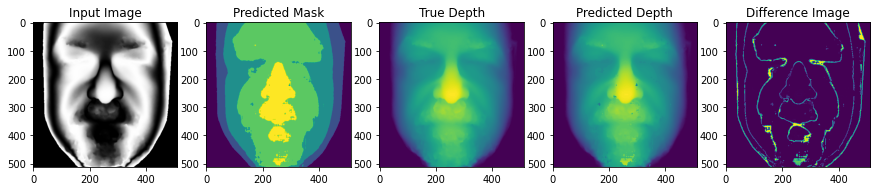

zmin: 0 zmax: 255 zrng: 255
min K 0.0 max K 2.0
min phase -3.1415927410125732 max phase 12.566370614359172
P 127.5 zrng 255
Average absolute error 0.3240076463899613
Actual Min Depth: 0.0 Max Depth: 255.0
Predicted Min Depth: 0.0 Max Depth: 255.0


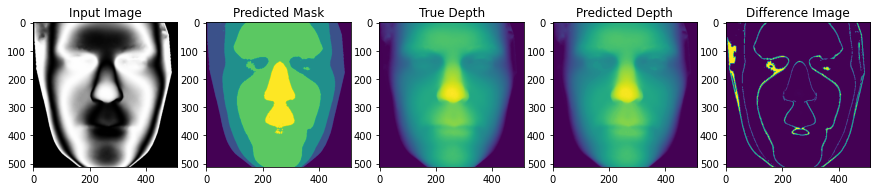

zmin: 0 zmax: 255 zrng: 255
min K 0.0 max K 2.0
min phase -3.1415927410125732 max phase 12.566370614359172
P 127.5 zrng 255
Average absolute error 0.28502893378275224
Actual Min Depth: 0.0 Max Depth: 255.0
Predicted Min Depth: 0.0 Max Depth: 255.0


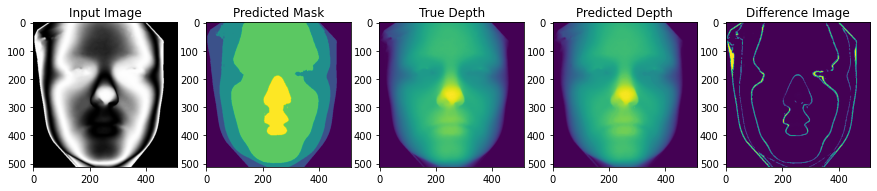

zmin: 0 zmax: 255 zrng: 255
min K 0.0 max K 2.0
min phase -3.1415927410125732 max phase 12.566370614359172
P 127.5 zrng 255
Average absolute error 1.6567804212076402
Actual Min Depth: 0.0 Max Depth: 255.0
Predicted Min Depth: 0.0 Max Depth: 255.0


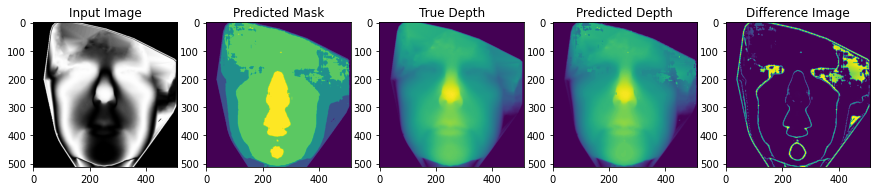

zmin: 0 zmax: 255 zrng: 255
min K 0.0 max K 2.0
min phase -3.1415927410125732 max phase 12.566370614359172
P 127.5 zrng 255
Average absolute error 0.6576367861855092
Actual Min Depth: 0.0 Max Depth: 255.0
Predicted Min Depth: 0.0 Max Depth: 255.0


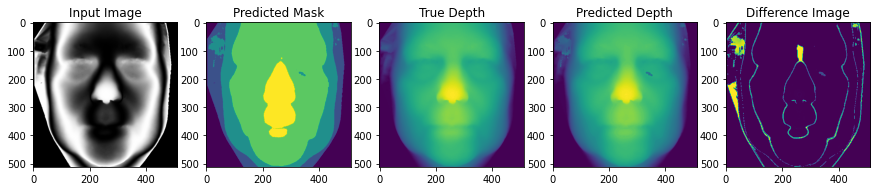

zmin: 0 zmax: 255 zrng: 255
min K 0.0 max K 2.0
min phase -3.1415927410125732 max phase 12.566370614359172
P 127.5 zrng 255
Average absolute error 0.5159923322709213
Actual Min Depth: 0.0 Max Depth: 255.0
Predicted Min Depth: 0.0 Max Depth: 255.0


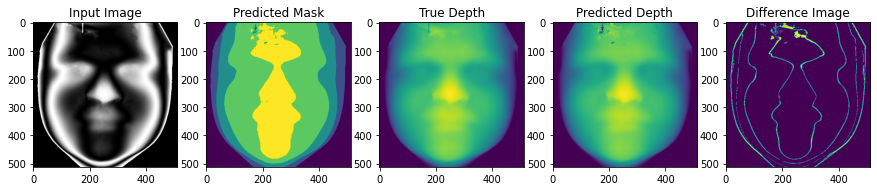

zmin: 0 zmax: 255 zrng: 255
min K 0.0 max K 2.0
min phase -3.1415927410125732 max phase 12.566370614359172
P 127.5 zrng 255
Average absolute error 0.36746086668584044
Actual Min Depth: 0.0 Max Depth: 255.0
Predicted Min Depth: 0.0 Max Depth: 255.0


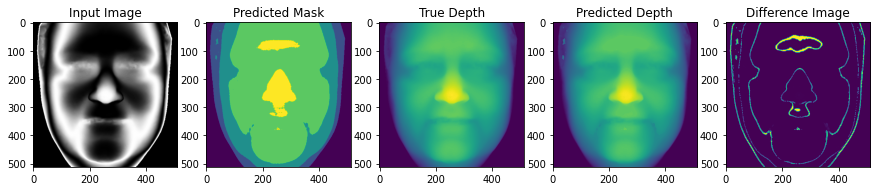

zmin: 0 zmax: 254 zrng: 254
min K 0.0 max K 2.0
min phase -3.1415927410125732 max phase 12.566370614359172
P 127.0 zrng 254
Average absolute error 0.428546293099345
Actual Min Depth: 0.0 Max Depth: 254.0
Predicted Min Depth: 0.0 Max Depth: 254.0


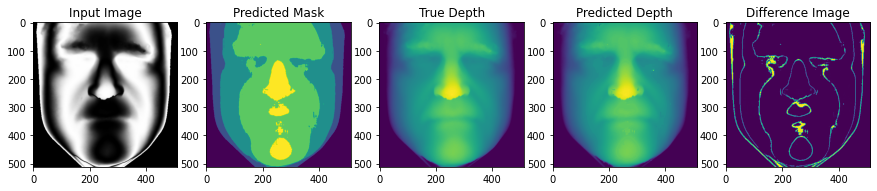

In [9]:
evaluate_predictions(test_dataset, 10)

## Create directory to save predicted depth info, then test all test_dataset

In [10]:
## Testing
if not os.path.isdir( '../Data/Dataset/Predicted_Depth/Testing'):
    os.makedirs('..Data/Dataset/Predicted_Depth/Testing', exist_ok=True)
    print("Generated directory: ..Data/Dataset/Predicted_Depth/Testing")
    
if not os.path.isdir( '../Data/Dataset/Original_Depth/Testing'):
    os.makedirs('..Data/Dataset/Original_Depth/Testing', exist_ok=True)
    print("Generated directory: ..Data/Dataset/Original_Depth/Testing")
    
if not os.path.isdir( '../Data/Dataset/Gamma_Map/Testing'):
    os.makedirs('..Data/Dataset/Gamma_Map/Testing', exist_ok=True)
    print("Generated directory: ..Data/Dataset/Gamma_Map/Testing")
    
if not os.path.isdir( '../Data/Dataset/Encoded_Image/Testing'):
    os.makedirs('..Data/Dataset/Encoded_Image/Testing', exist_ok=True)
    print("Generated directory: ..Data/Dataset/Encoded_Image/Testing")
    
if not os.path.isdir( '../Data/Dataset/Diff_Image/Testing'):
    os.makedirs('..Data/Dataset/Diff_Image/Testing', exist_ok=True)
    print("Generated directory: ..Data/Dataset/Diff_Image/Testing")
    
if not os.path.isdir( '../Data/Dataset/Original_Depth_Grayscale/Testing'):
    os.makedirs('..Data/Dataset/Original_Depth_Grayscale/Testing', exist_ok=True)
    print("Generated directory: ..Data/Dataset/Original_Depth_Grayscale/Testing")
    
if not os.path.isdir( '../Data/Dataset/Predicted_Depth_Grayscale/Testing'):
    os.makedirs('..Data/Dataset/Predicted_Depth_Grayscale/Testing', exist_ok=True)
    print("Generated directory: ..Data/Dataset/Predicted_Depth_Grayscale/Testing")
    
## Training
if not os.path.isdir( '../Data/Dataset/Predicted_Depth/Training'):
    os.makedirs('..Data/Dataset/Predicted_Depth/Training', exist_ok=True)
    print("Generated directory: ..Data/Dataset/Predicted_Depth/Training")
    
if not os.path.isdir( '../Data/Dataset/Original_Depth/Training'):
    os.makedirs('..Data/Dataset/Original_Depth/Training', exist_ok=True)
    print("Generated directory: ..Data/Dataset/Original_Depth/Training")
    
if not os.path.isdir( '../Data/Dataset/Gamma_Map/Training'):
    os.makedirs('..Data/Dataset/Gamma_Map/Training', exist_ok=True)
    print("Generated directory: ..Data/Dataset/Gamma_Map/Training")
    
if not os.path.isdir( '../Data/Dataset/Encoded_Image/Training'):
    os.makedirs('..Data/Dataset/Encoded_Image/Training', exist_ok=True)
    print("Generated directory: ..Data/Dataset/Encoded_Image/Training")
    
if not os.path.isdir( '../Data/Dataset/Diff_Image/Training'):
    os.makedirs('..Data/Dataset/Diff_Image/Training', exist_ok=True)
    print("Generated directory: ..Data/Dataset/Diff_Image/Training")
    
if not os.path.isdir( '../Data/Dataset/Original_Depth_Grayscale/Training'):
    os.makedirs('..Data/Dataset/Original_Depth_Grayscale/Training', exist_ok=True)
    print("Generated directory: ..Data/Dataset/Original_Depth_Grayscale/Training")
    
if not os.path.isdir( '../Data/Dataset/Predicted_Depth_Grayscale/Training'):
    os.makedirs('..Data/Dataset/Predicted_Depth_Grayscale/Training', exist_ok=True)
    print("Generated directory: ..Data/Dataset/Predicted_Depth_Grayscale/Training")


In [13]:
evaluate_all_data(train_dataset, save_images=True, train=True)
evaluate_all_data(test_dataset, save_images=True, train=False)

Number of Images Tested:  919
RMS Error:  2.297763557233299
Number of Images Tested:  230
RMS Error:  3.9525251324455724
